# Comparing constraints from different surveys

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Define utility functions for plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))

def shade_Gaussian(cov, pos, ind, nstds=[1,2], ax=None, alphas = [.1,.2], **kwargs):
    mu = pos[ind]
    sigma = np.sqrt(cov[ind,ind])

    if ax is None:
        ax = plt.gca()

    color = 'C0'
    if 'color' in kwargs.keys():
        color = kwargs['color']
    
    num = 100
    if 'num' in kwargs.keys():
        num = kwargs['num']
    
    curve = lambda x: np.exp(-.5*((x-mu)/sigma)**2)

    nstds = np.flip(np.sort(nstds))
    for i in range(len(nstds)):
        X = np.linspace(mu-nstds[i]*sigma, mu+nstds[i]*sigma, num=int(num*nstds[i]/nstds[0]), endpoint=True)
        ax.fill_between(X, curve(X), color=color, alpha=alphas[i])

In [3]:
#Methods to easily save and load fisher matrices to storage
from numpy import savetxt, loadtxt

def saveFisher(fid_vals, fisher, fname='gammaprime_S8_LSSTY1_fisher.csv', delimiter=',', **kwargs):
   mat = np.append(fisher, np.reshape(fid_vals, (1, fisher.shape[0])), axis=0)
   savetxt(fname, mat, delimiter=delimiter, **kwargs)


def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

## S8-$\Omega_m$ with $\gamma'$

In [4]:
# probe order of 3x2pt, galaxy clustering, galaxy-galaxy lensing, cosmic shear
probeNames = ('3x2', 'GC', 'GL', 'CS')

In [5]:
LSST_fishers = []
fid = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_LSSTY1_%s_fisher.csv' % (probe), delimiter=',')
    LSST_fishers.append(fisher)
    fid.append(fid_vals)

DES_fishers = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_DESY3_%s_fisher.csv' % (probe), delimiter=',')
    DES_fishers.append(fisher)

Euclid_fishers = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_Euclid_%s_fisher.csv' % (probe), delimiter=',')
    Euclid_fishers.append(fisher)

In [6]:
'''for i in range(len(probeNames)):
    LSST_fishers[i] = np.linalg.inv(LSST_fishers[i])
    DES_fishers[i] = np.linalg.inv(DES_fishers[i])
    Euclid_fishers[i] = np.linalg.inv(Euclid_fishers[i])'''


'for i in range(len(probeNames)):\n    LSST_fishers[i] = np.linalg.inv(LSST_fishers[i])\n    DES_fishers[i] = np.linalg.inv(DES_fishers[i])\n    Euclid_fishers[i] = np.linalg.inv(Euclid_fishers[i])'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


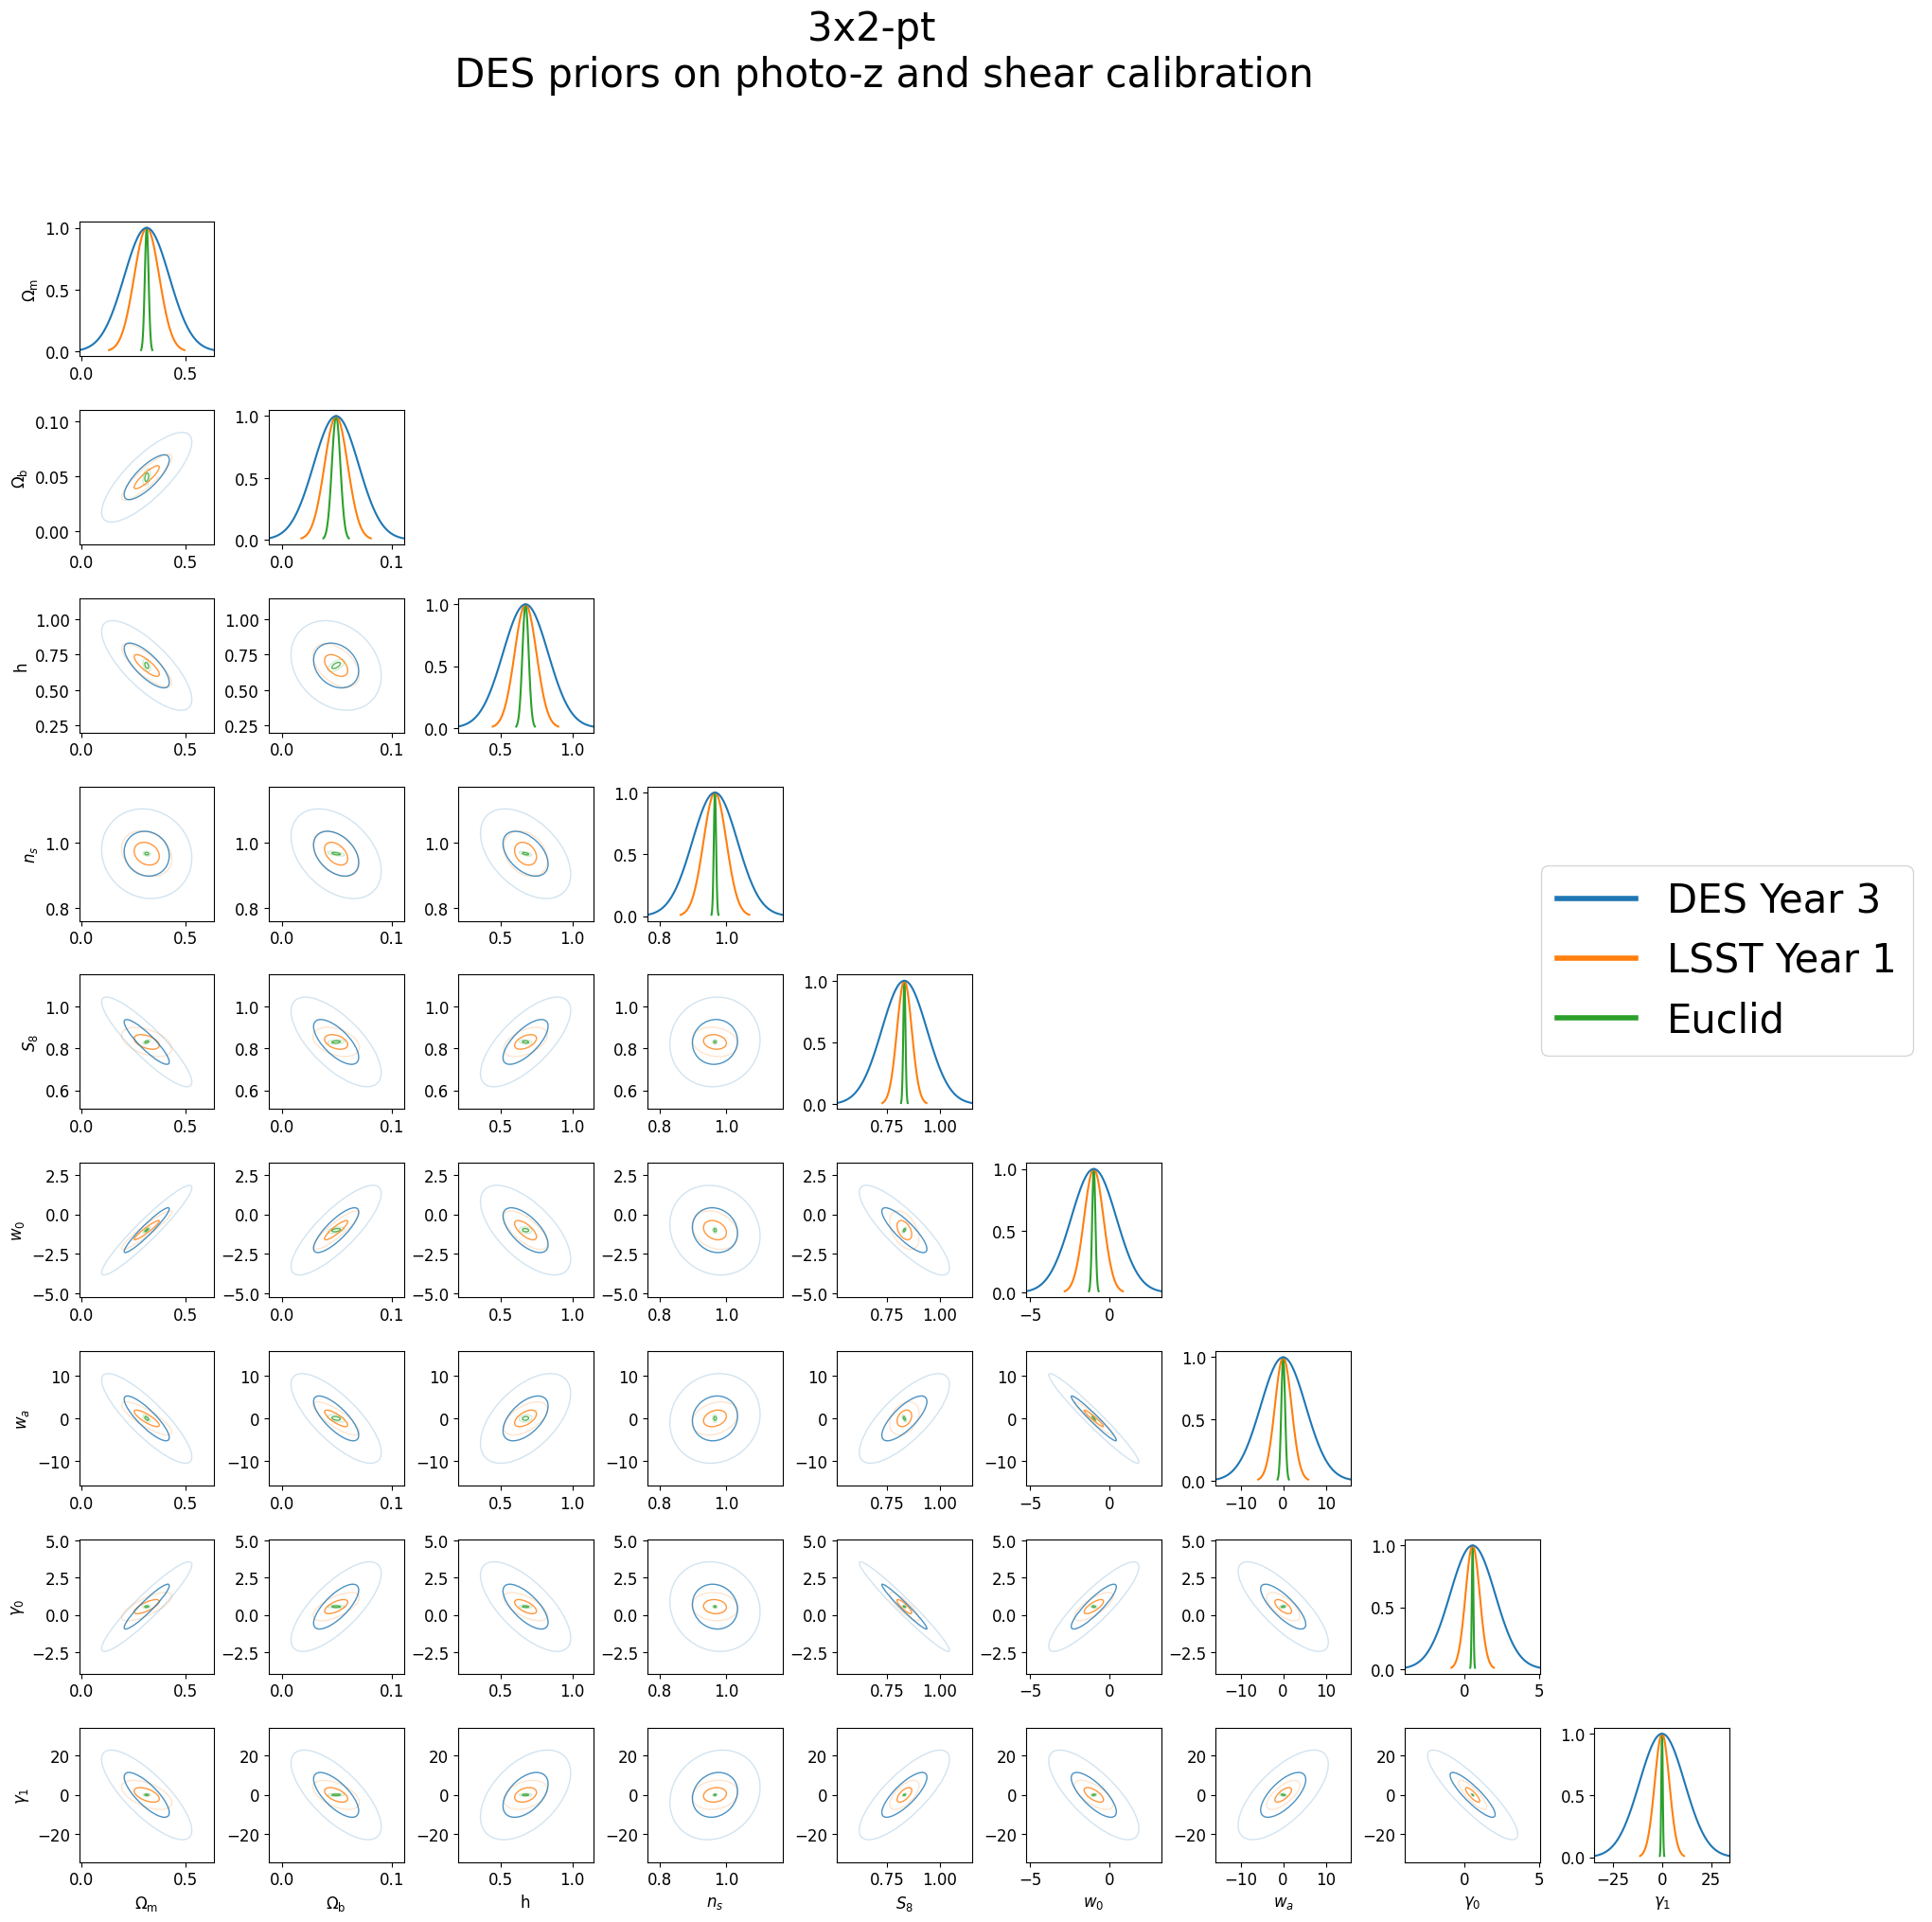

In [7]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_DES = np.linalg.inv(DES_fishers[0])
cov_LSST = np.linalg.inv(LSST_fishers[0])
cov_Euclid = np.linalg.inv(Euclid_fishers[0])
cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_Euclid, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_LSST, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
            plot_contours(cov_DES, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C0')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_Euclid, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_LSST, cosmo_fid_vals, i, color='C1')
            plot_Gaussian(cov_DES, cosmo_fid_vals, i, color='C0')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('3x2-pt \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C2', lw=4)]
fig.legend(legend_lines, ['DES Year 3', 'LSST Year 1', 'Euclid'], fontsize=30, loc='center right')

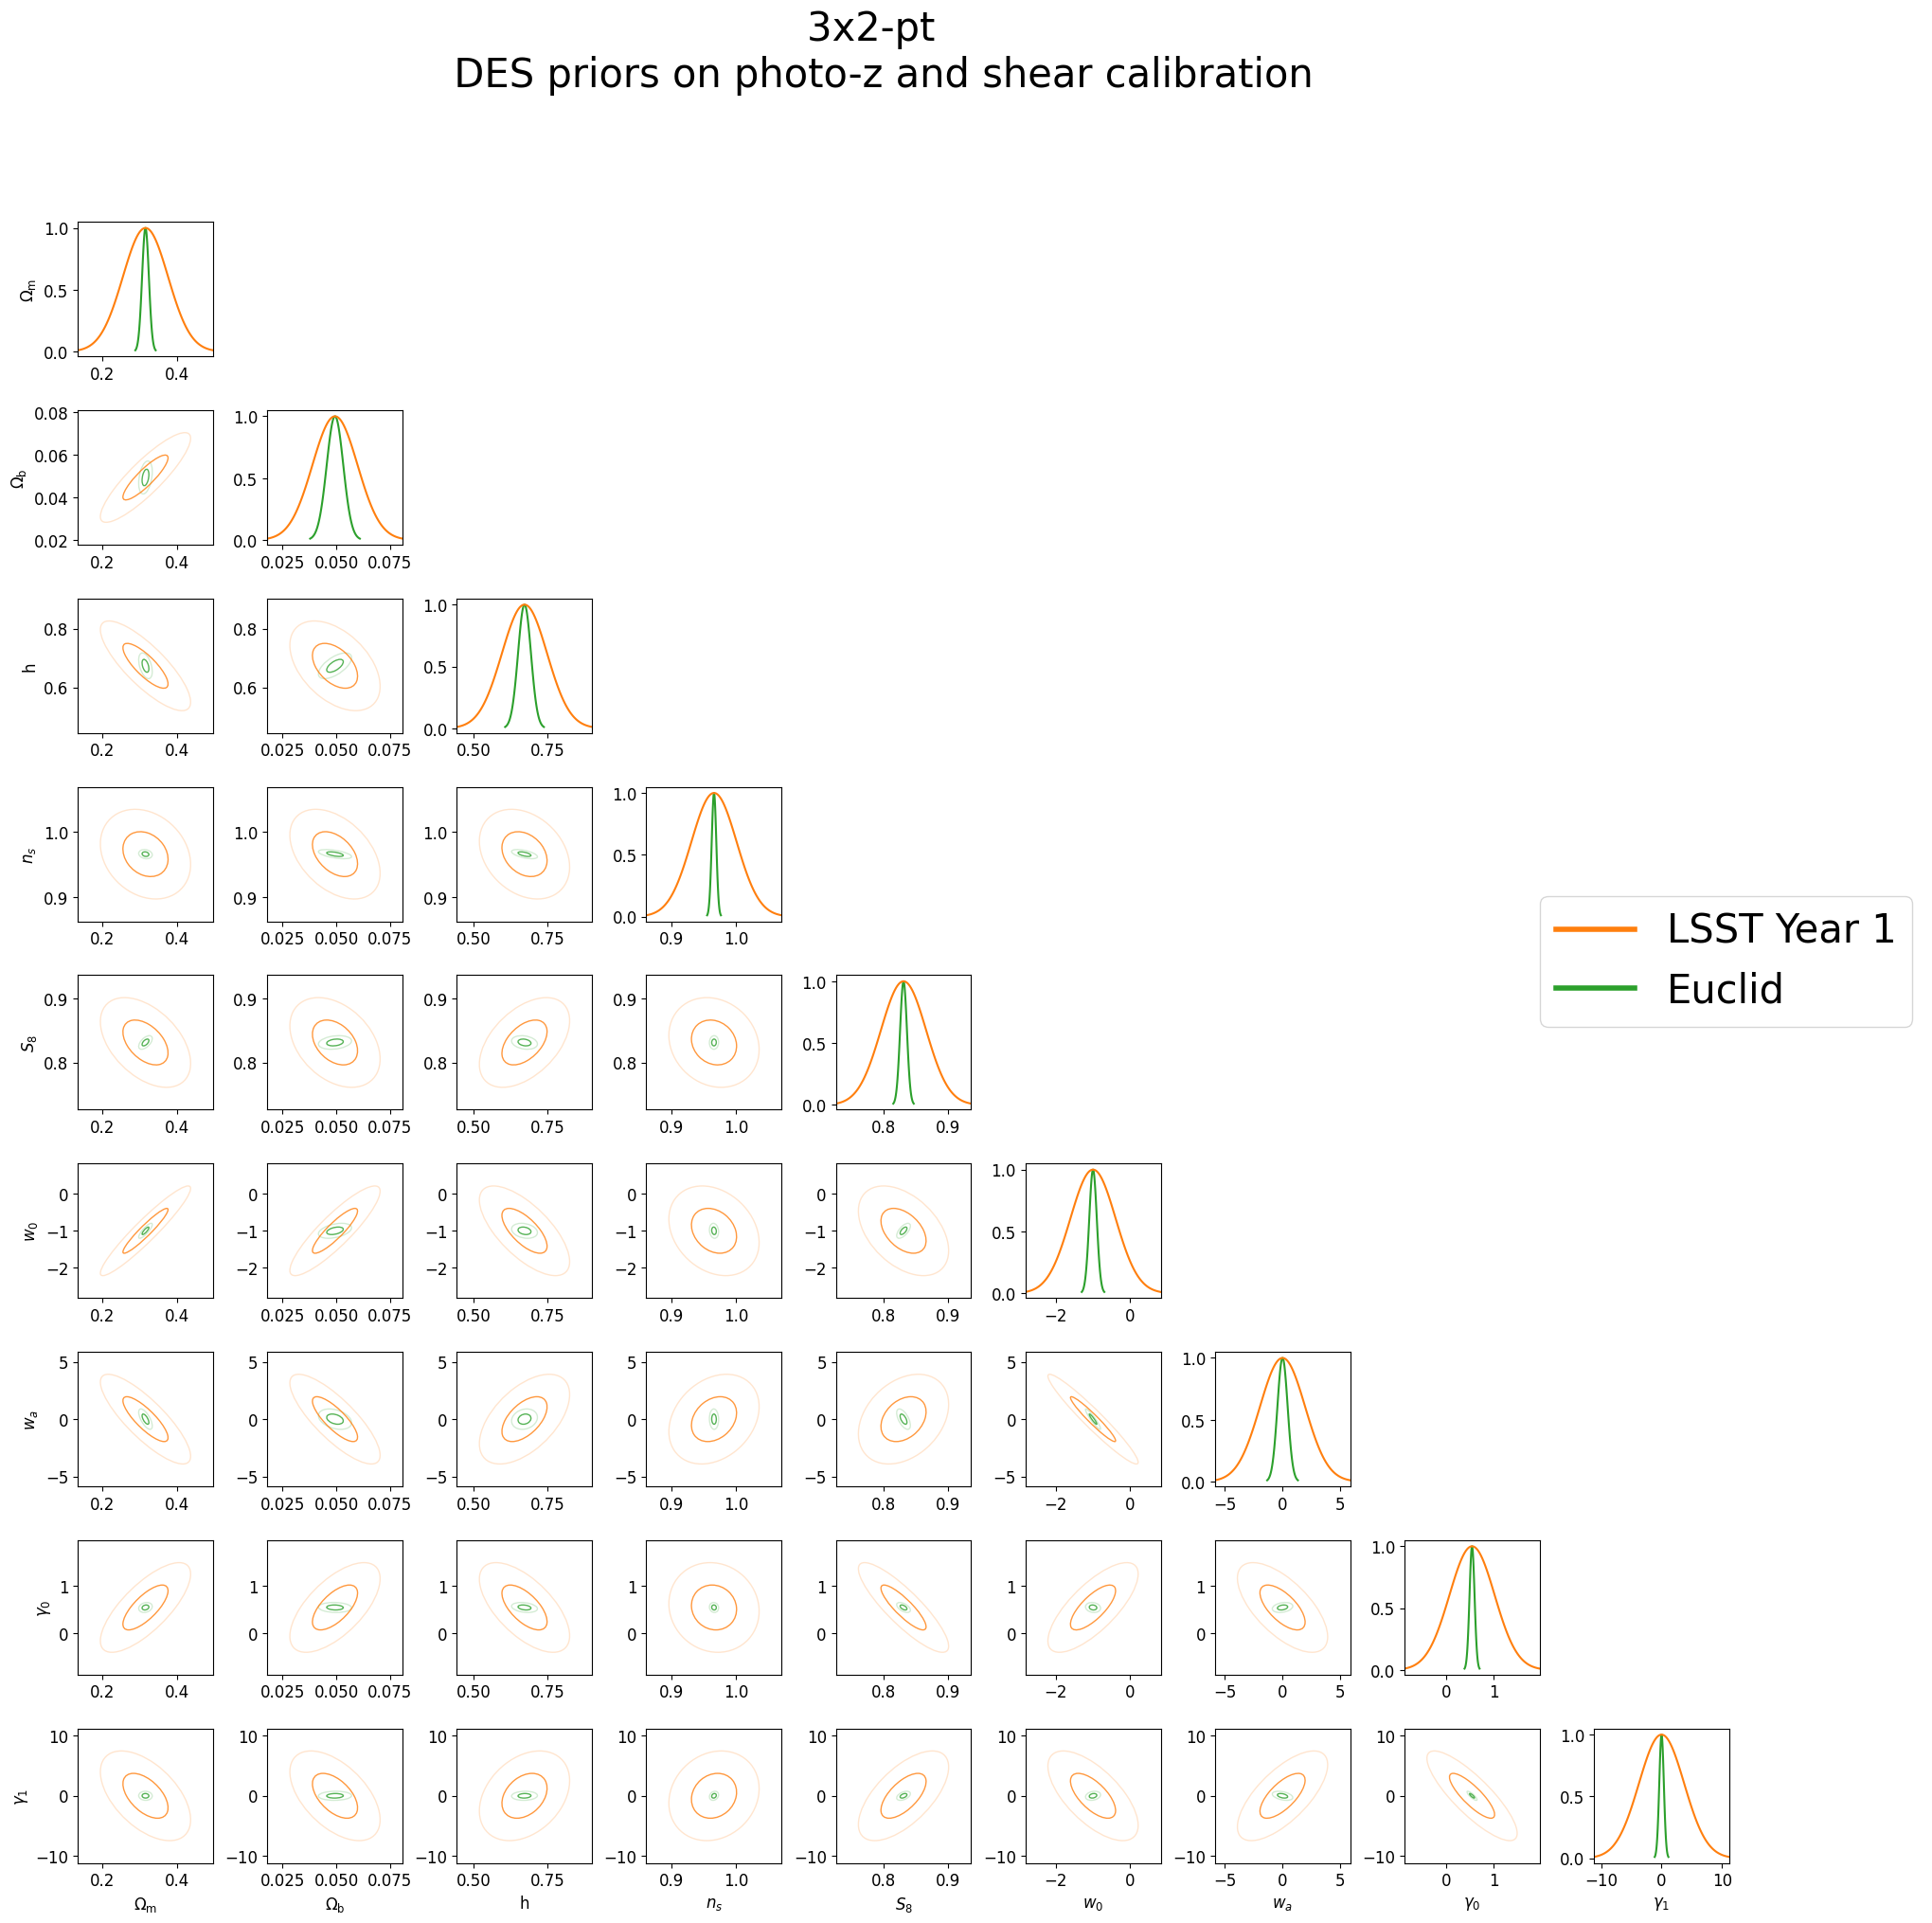

In [8]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_DES = np.linalg.inv(DES_fishers[0])
cov_LSST = np.linalg.inv(LSST_fishers[0])
cov_Euclid = np.linalg.inv(Euclid_fishers[0])
cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_Euclid, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_LSST, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_Euclid, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_LSST, cosmo_fid_vals, i, color='C1')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('3x2-pt \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C2', lw=4)]
fig.legend(legend_lines, ['LSST Year 1', 'Euclid'], fontsize=30, loc='center right')

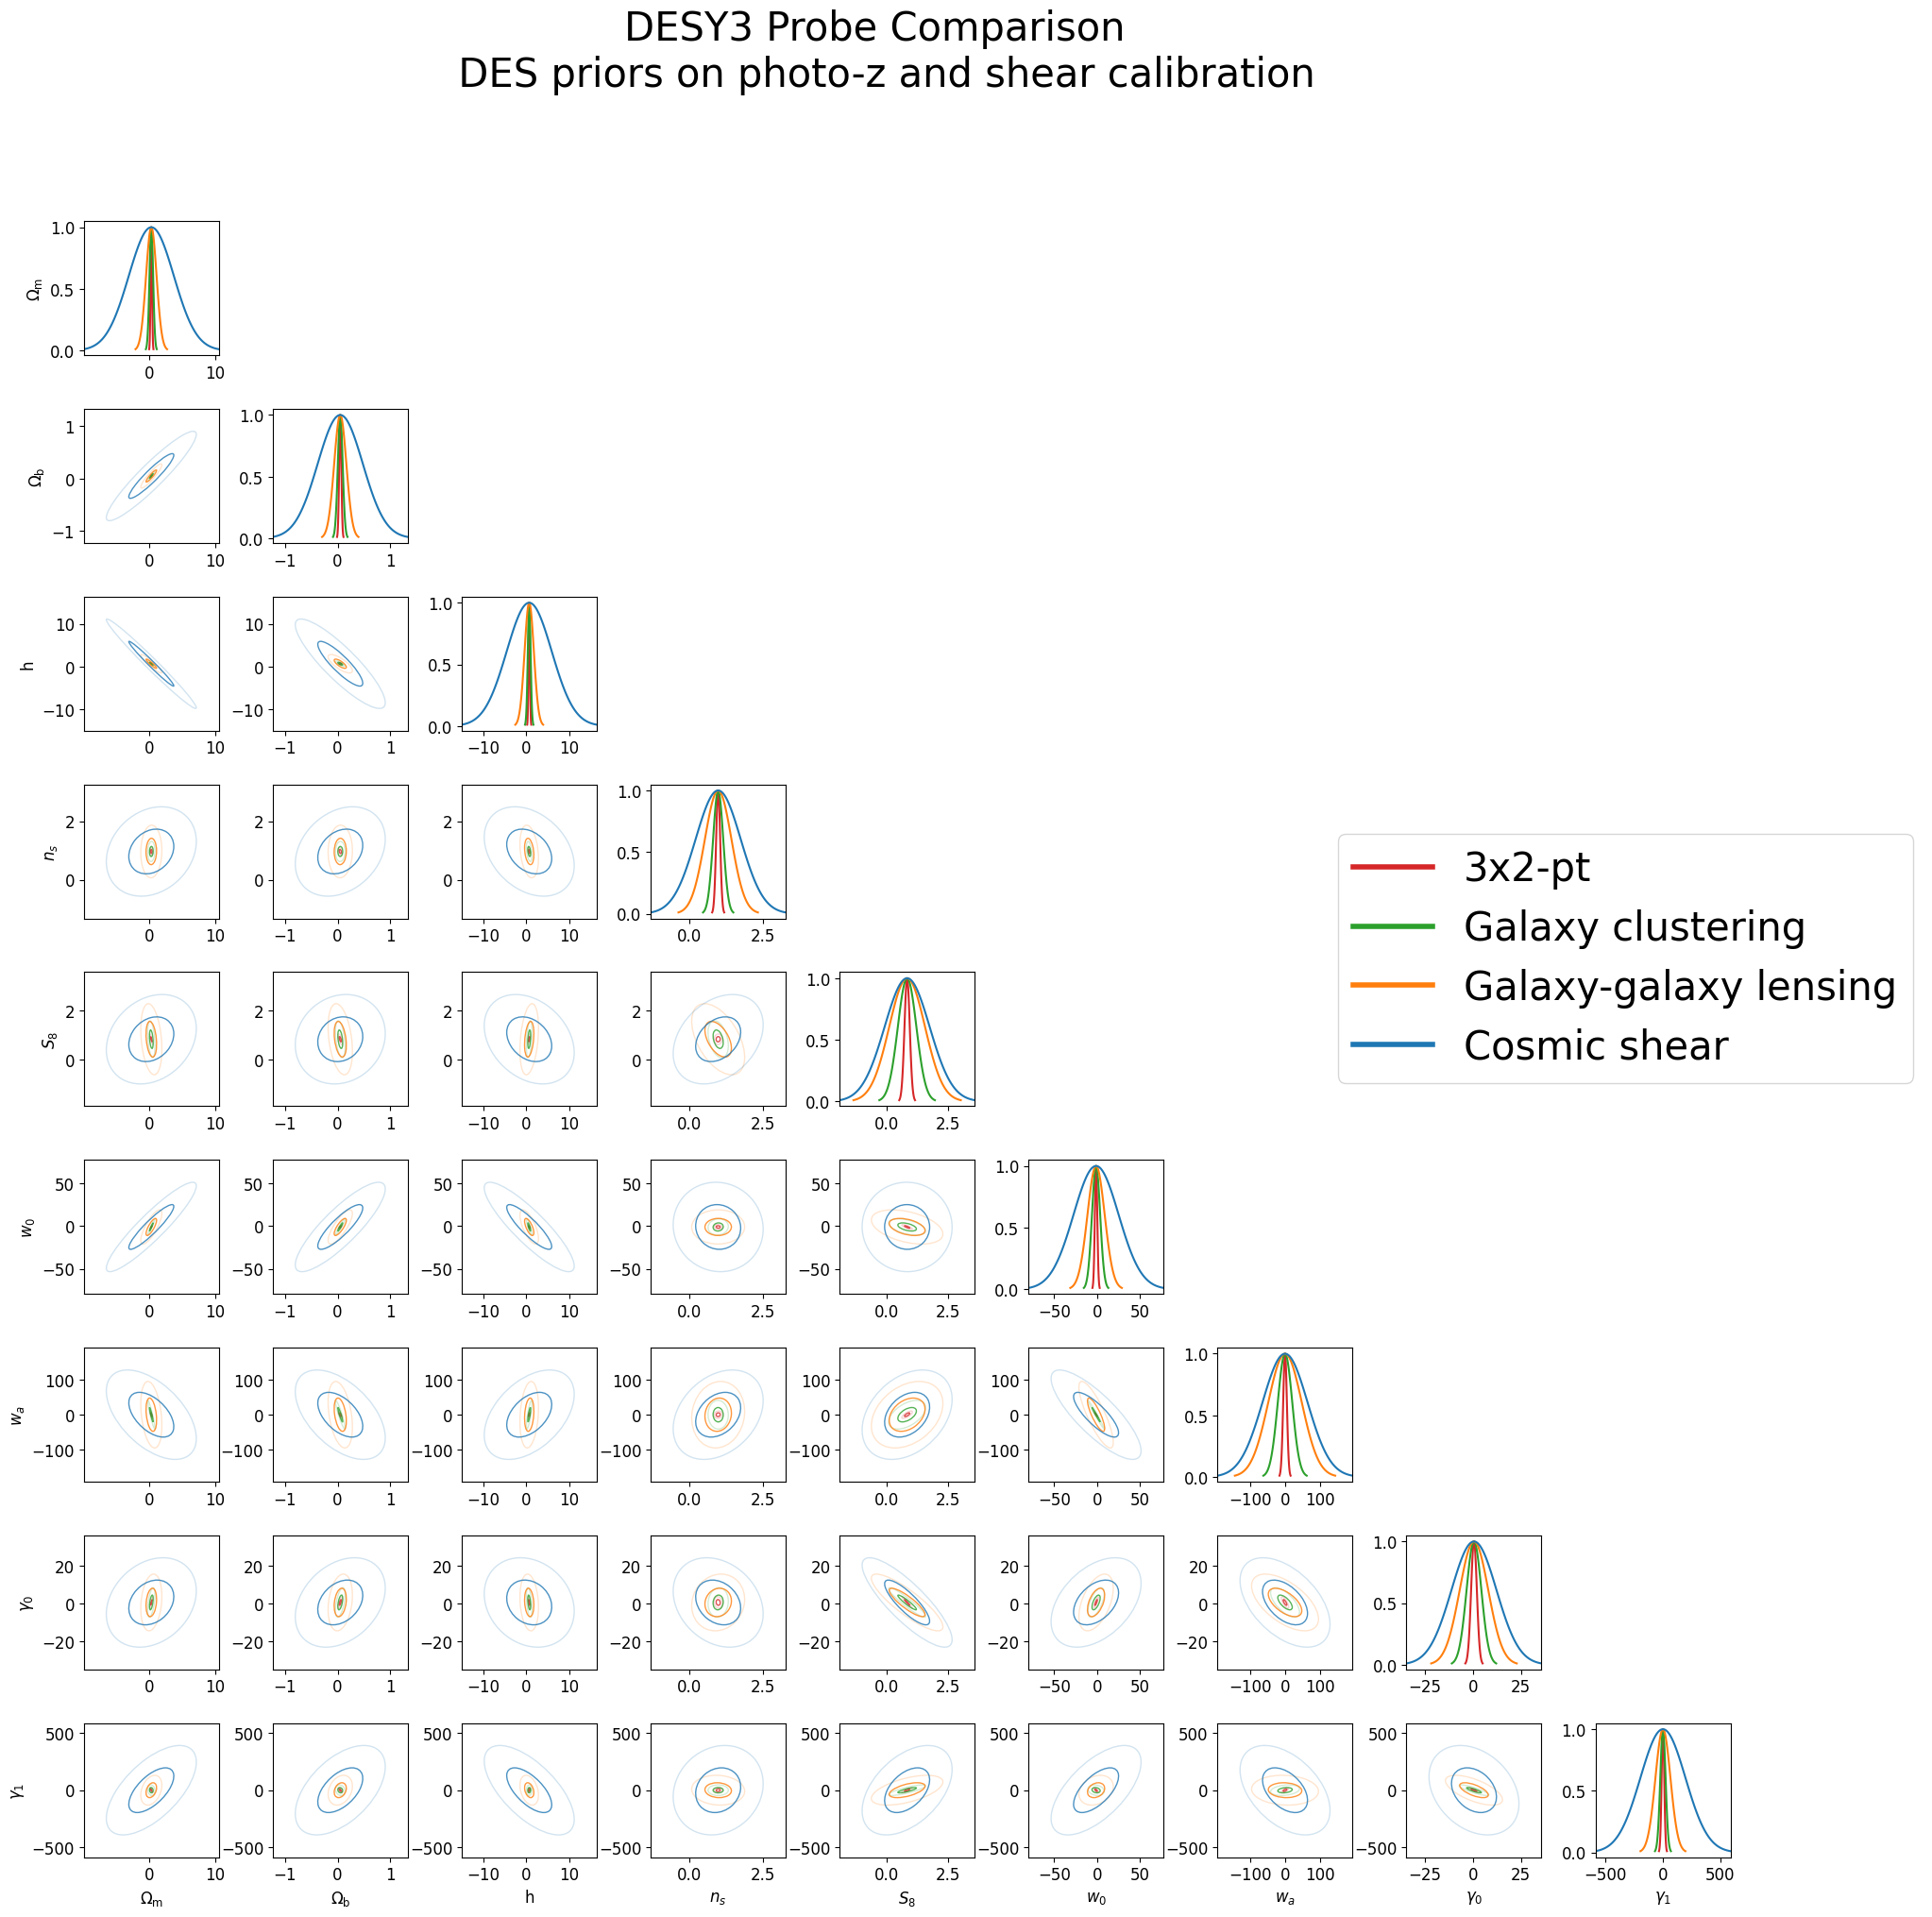

In [9]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_3x2 = np.linalg.inv(DES_fishers[0])
cov_GC = np.linalg.inv(DES_fishers[1])
cov_GL = np.linalg.inv(DES_fishers[2])
cov_CS = np.linalg.inv(DES_fishers[3])

cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_3x2, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C3')
            plot_contours(cov_GC, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_GL, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
            plot_contours(cov_CS, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C0')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_3x2, cosmo_fid_vals, i, color='C3')
            plot_Gaussian(cov_GC, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_GL, cosmo_fid_vals, i, color='C1')
            plot_Gaussian(cov_CS, cosmo_fid_vals, i, color='C0')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('DESY3 Probe Comparison \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C3', lw=4),
                Line2D([0], [0], color='C2', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C0', lw=4)]
fig.legend(legend_lines, ['3x2-pt', 'Galaxy clustering', 'Galaxy-galaxy lensing', 'Cosmic shear'], fontsize=30, loc='center right')

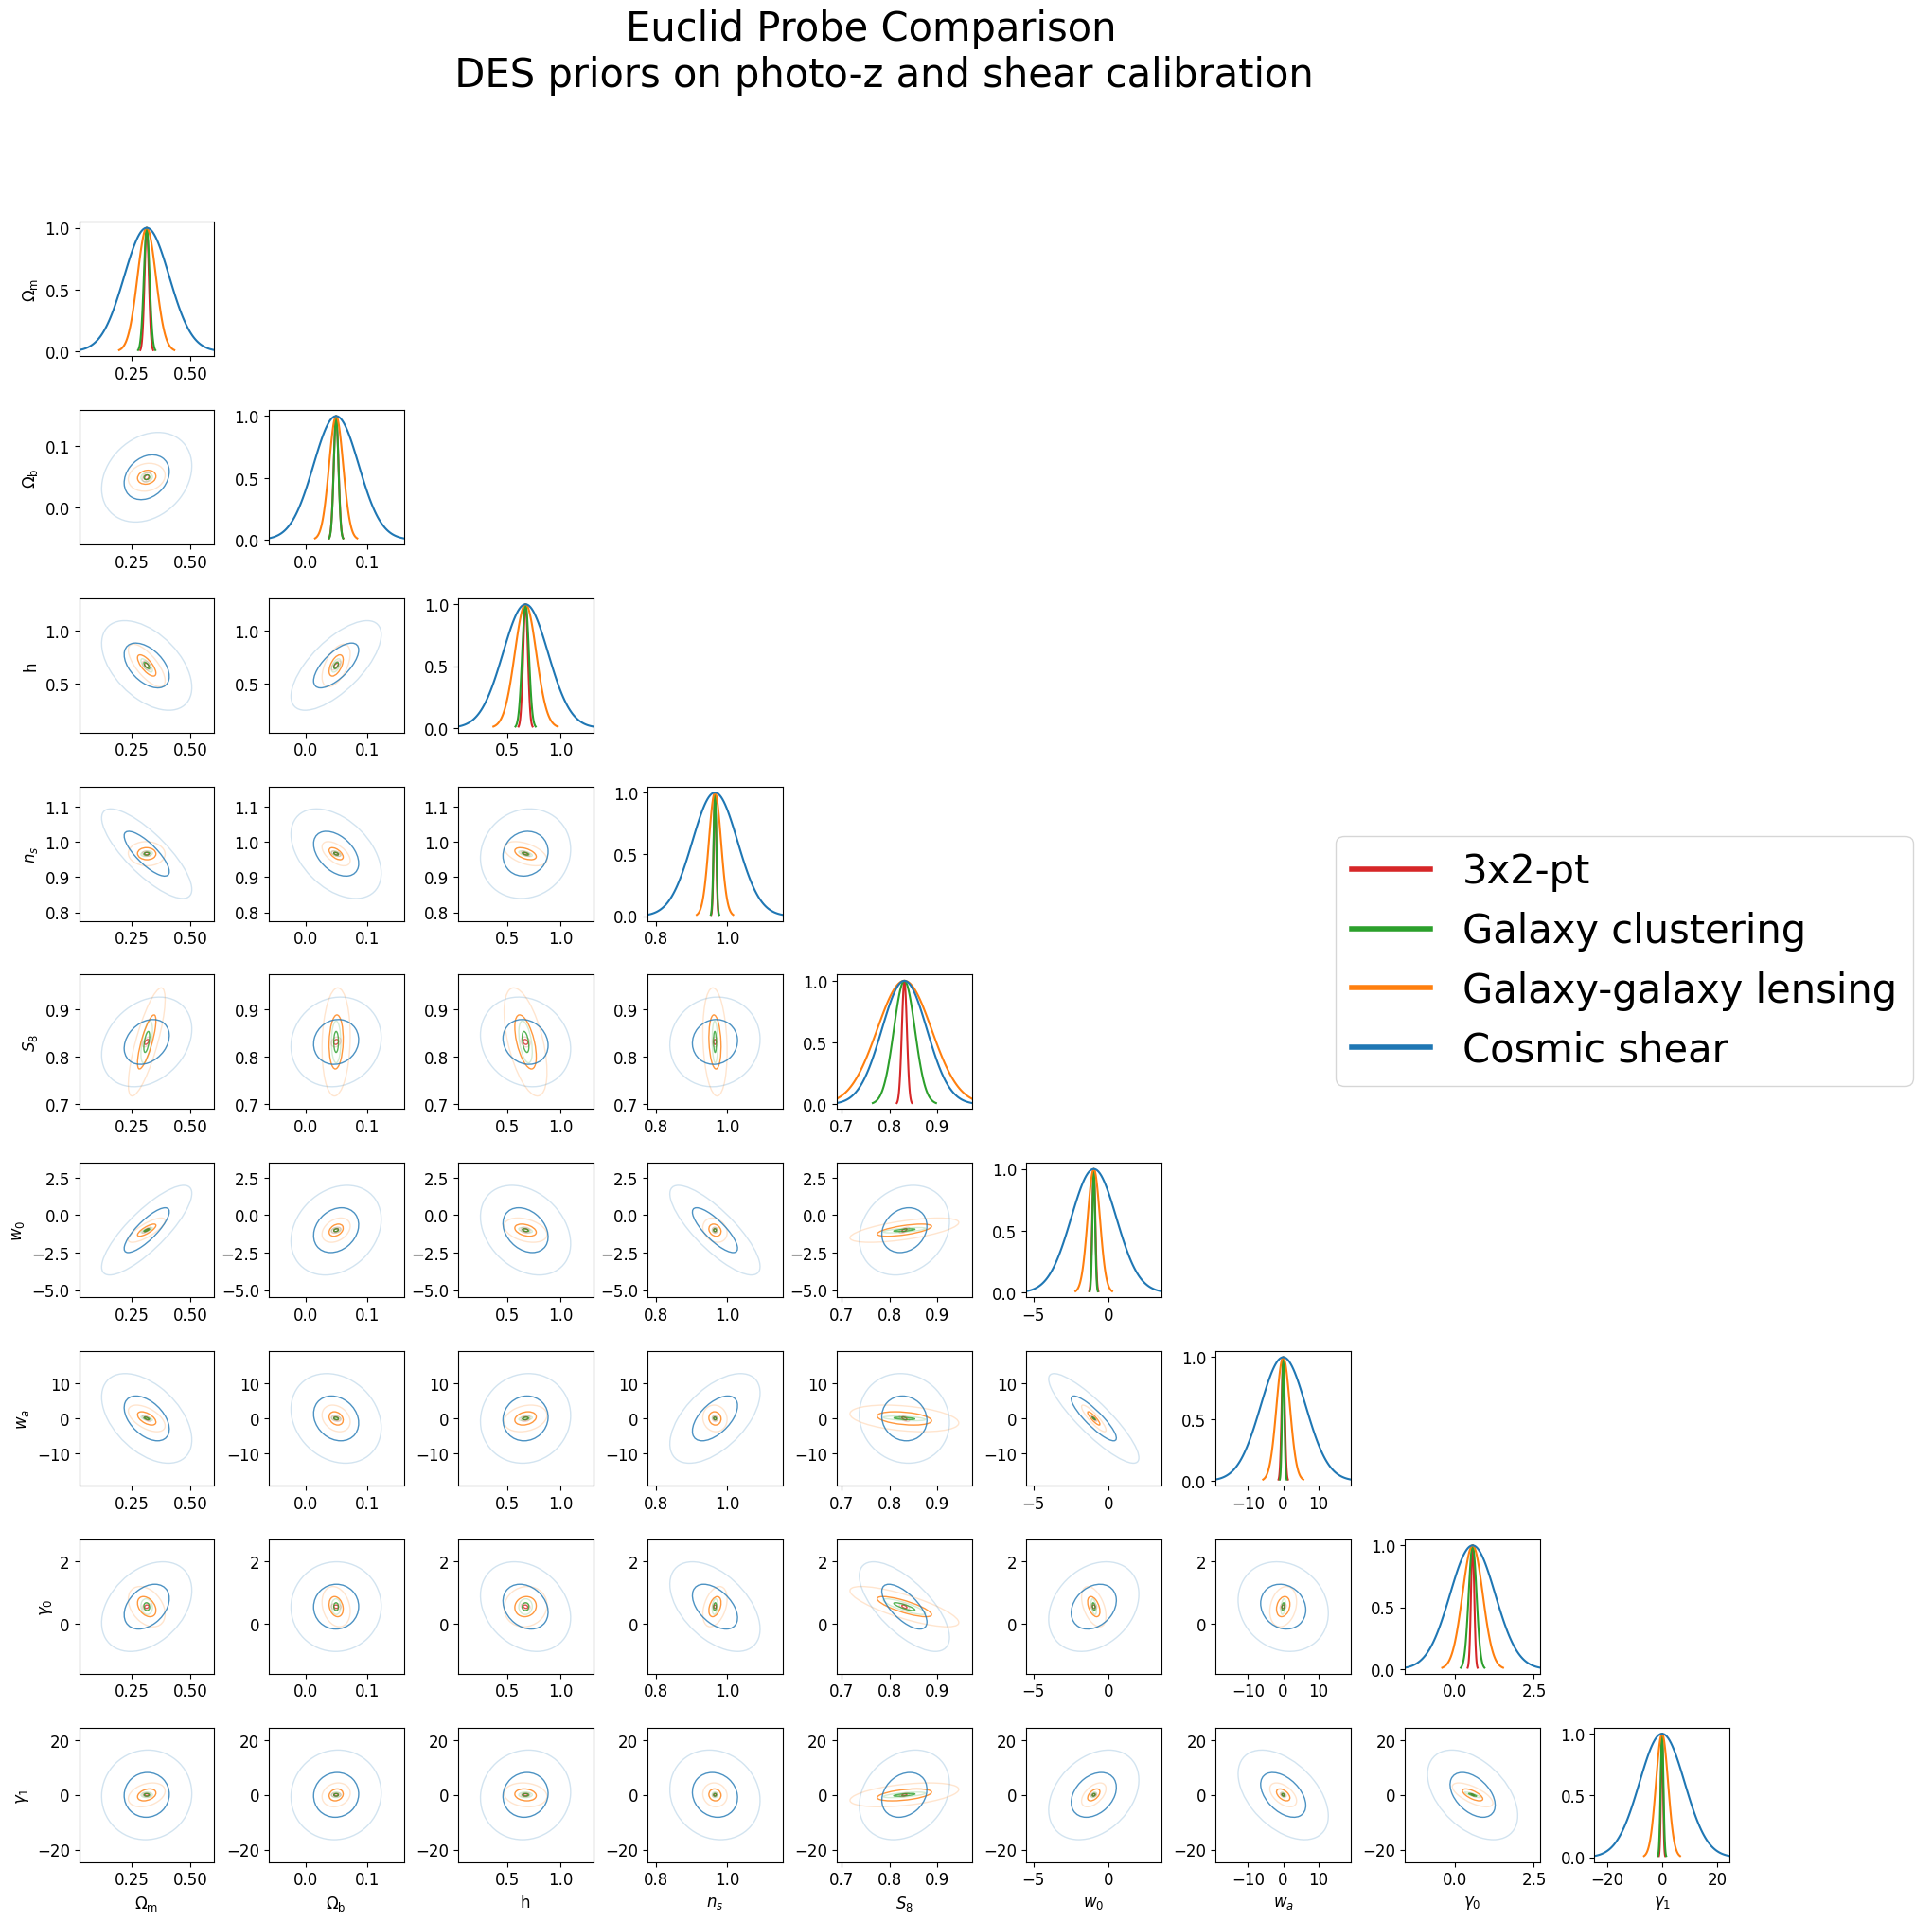

In [10]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_3x2 = np.linalg.inv(Euclid_fishers[0])
cov_GC = np.linalg.inv(Euclid_fishers[1])
cov_GL = np.linalg.inv(Euclid_fishers[2])
cov_CS = np.linalg.inv(Euclid_fishers[3])

cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_3x2, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C3')
            plot_contours(cov_GC, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_GL, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
            plot_contours(cov_CS, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C0')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_3x2, cosmo_fid_vals, i, color='C3')
            plot_Gaussian(cov_GC, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_GL, cosmo_fid_vals, i, color='C1')
            plot_Gaussian(cov_CS, cosmo_fid_vals, i, color='C0')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('Euclid Probe Comparison \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C3', lw=4),
                Line2D([0], [0], color='C2', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C0', lw=4)]
fig.legend(legend_lines, ['3x2-pt', 'Galaxy clustering', 'Galaxy-galaxy lensing', 'Cosmic shear'], fontsize=30, loc='center right')

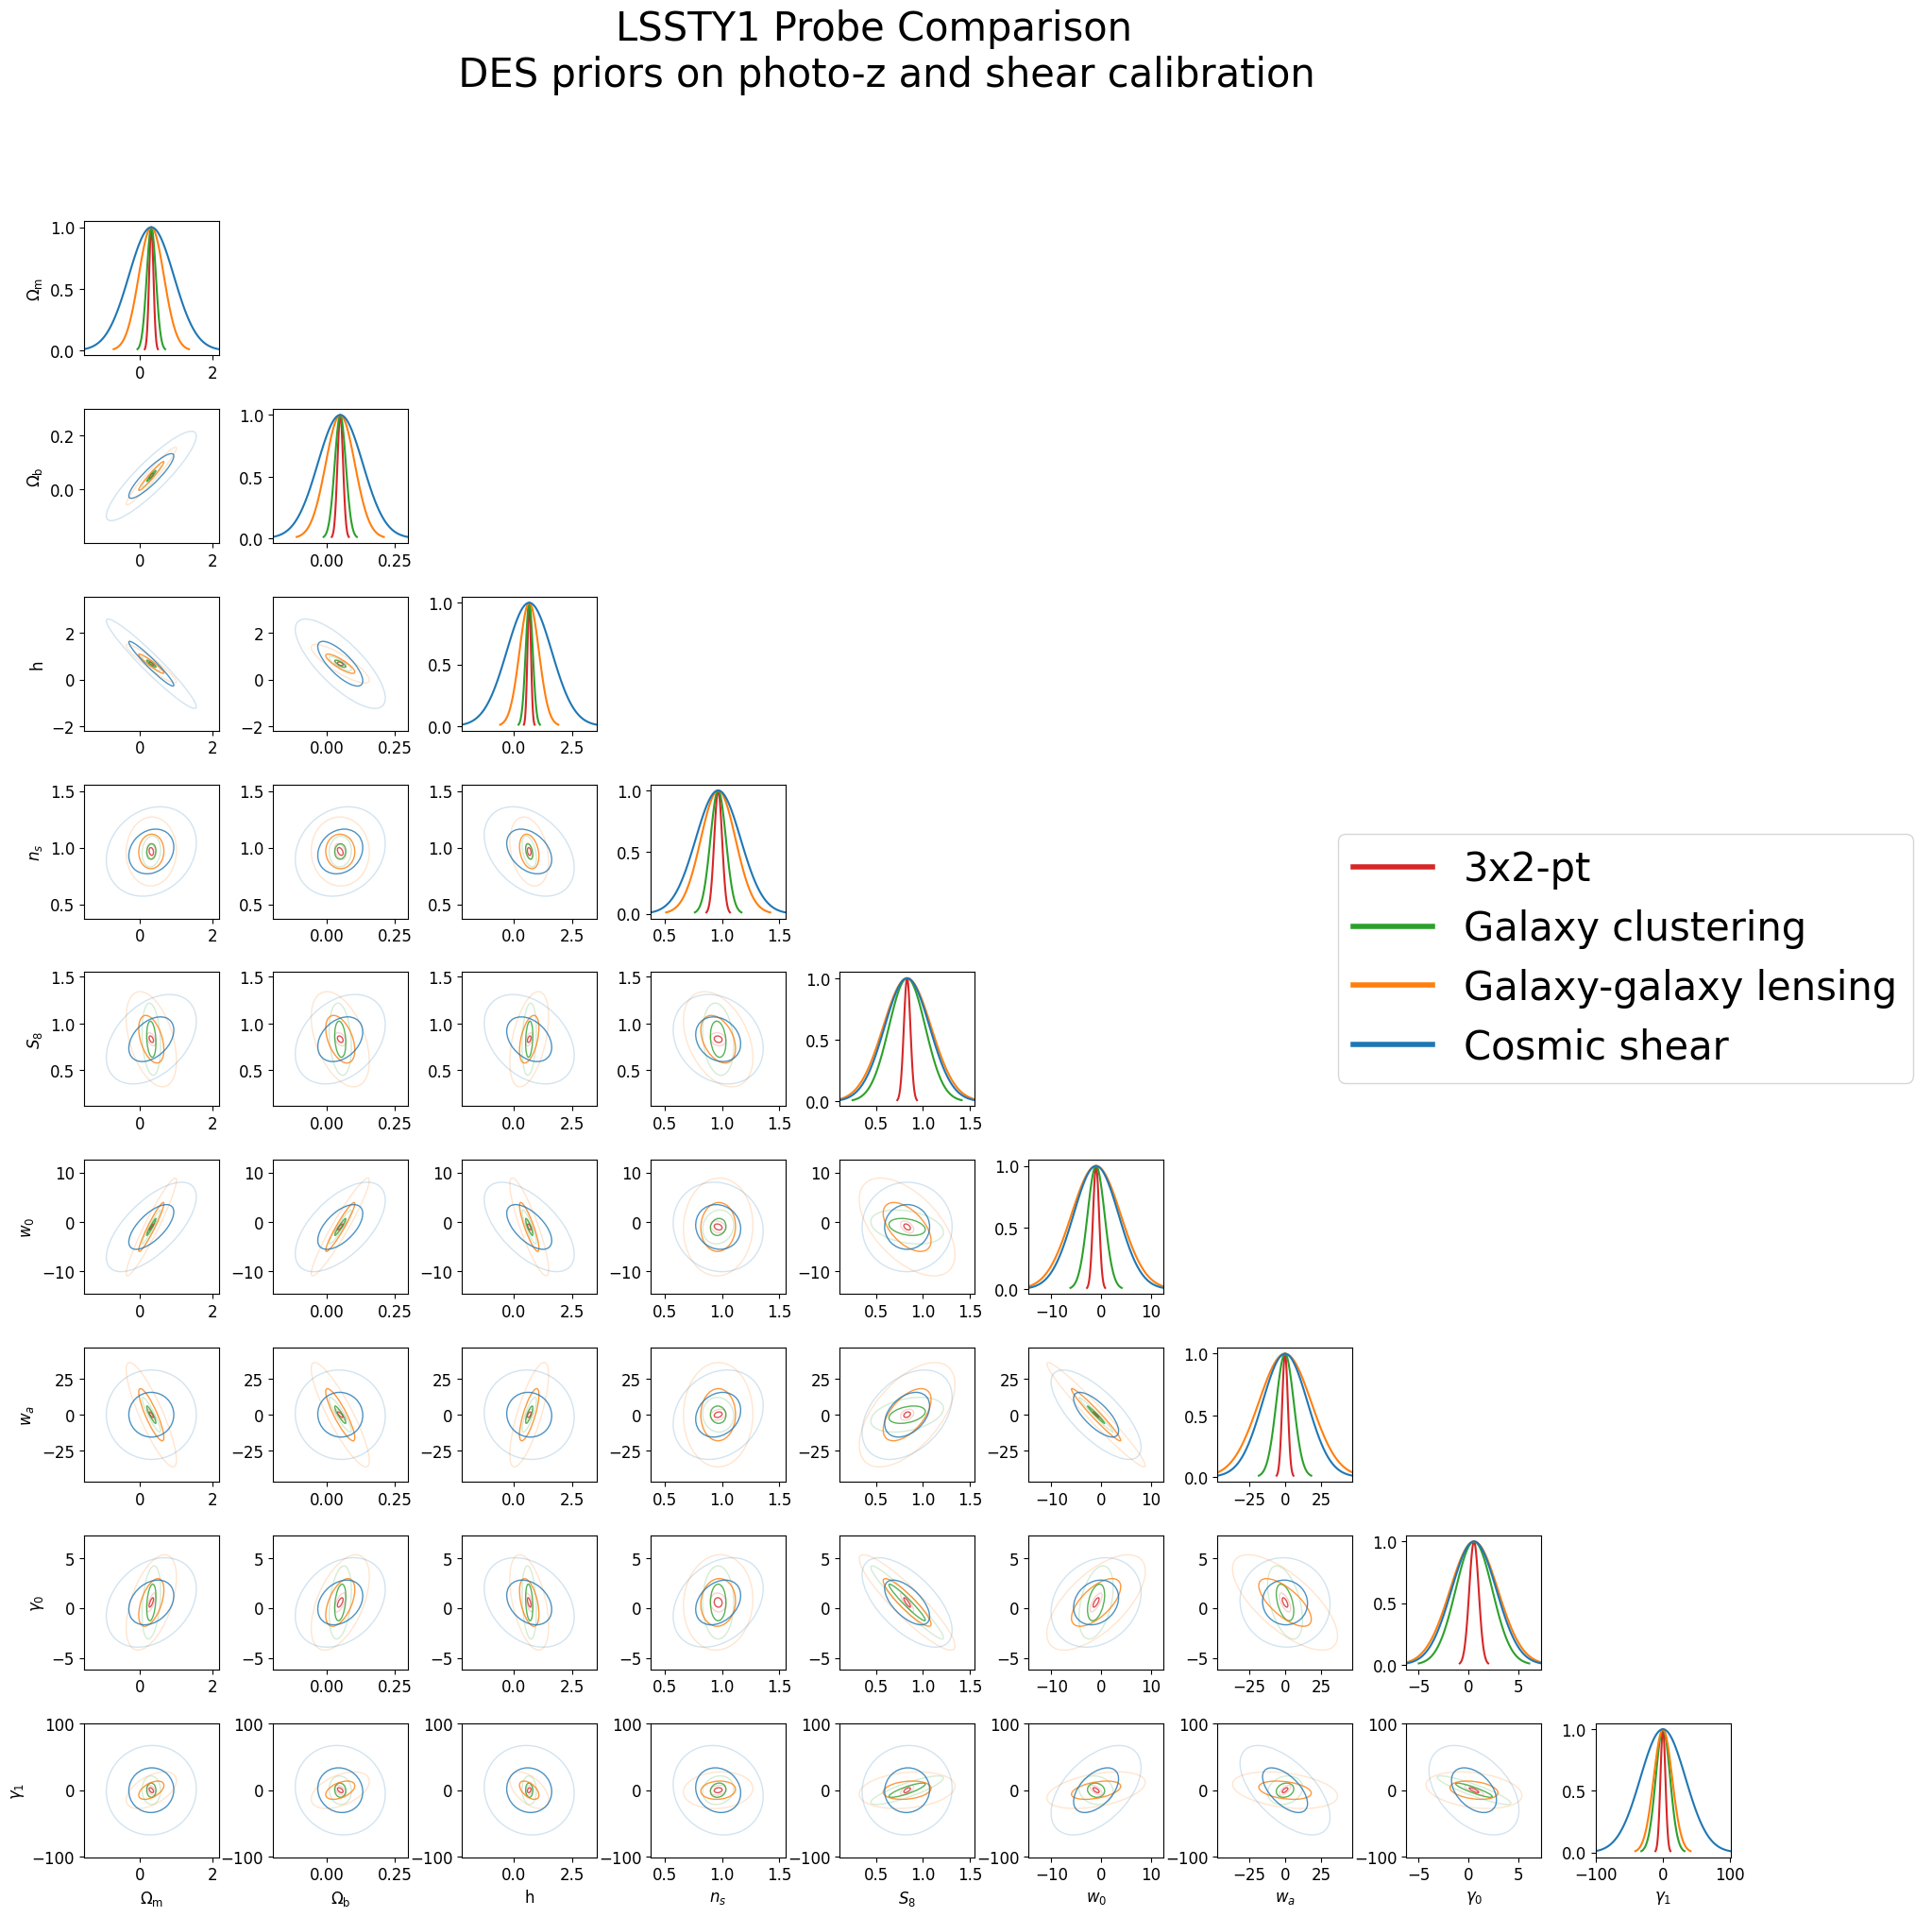

In [11]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_3x2 = np.linalg.inv(LSST_fishers[0])
cov_GC = np.linalg.inv(LSST_fishers[1])
cov_GL = np.linalg.inv(LSST_fishers[2])
cov_CS = np.linalg.inv(LSST_fishers[3])

cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_3x2, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C3')
            plot_contours(cov_GC, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_GL, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
            plot_contours(cov_CS, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C0')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_3x2, cosmo_fid_vals, i, color='C3')
            plot_Gaussian(cov_GC, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_GL, cosmo_fid_vals, i, color='C1')
            plot_Gaussian(cov_CS, cosmo_fid_vals, i, color='C0')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('LSSTY1 Probe Comparison \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C3', lw=4),
                Line2D([0], [0], color='C2', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C0', lw=4)]
fig.legend(legend_lines, ['3x2-pt', 'Galaxy clustering', 'Galaxy-galaxy lensing', 'Cosmic shear'], fontsize=30, loc='center right')

In [12]:
probeNames= ('3x2',)
LSST_fishers_noprior = []
fid = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_LSSTY1_%s_no-prior_fisher.csv' % (probe), delimiter=',')
    LSST_fishers_noprior.append(fisher)
    fid.append(fid_vals)

DES_fishers_noprior = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_DESY3_%s_no-prior_fisher.csv' % (probe), delimiter=',')
    DES_fishers_noprior.append(fisher)

Euclid_fishers_noprior = []
for probe in probeNames:
    fid_vals, fisher = loadFisher('Fishers/gammaprime_S8-Omegam_Euclid_%s_no-prior_fisher.csv' % (probe), delimiter=',')
    Euclid_fishers_noprior.append(fisher)

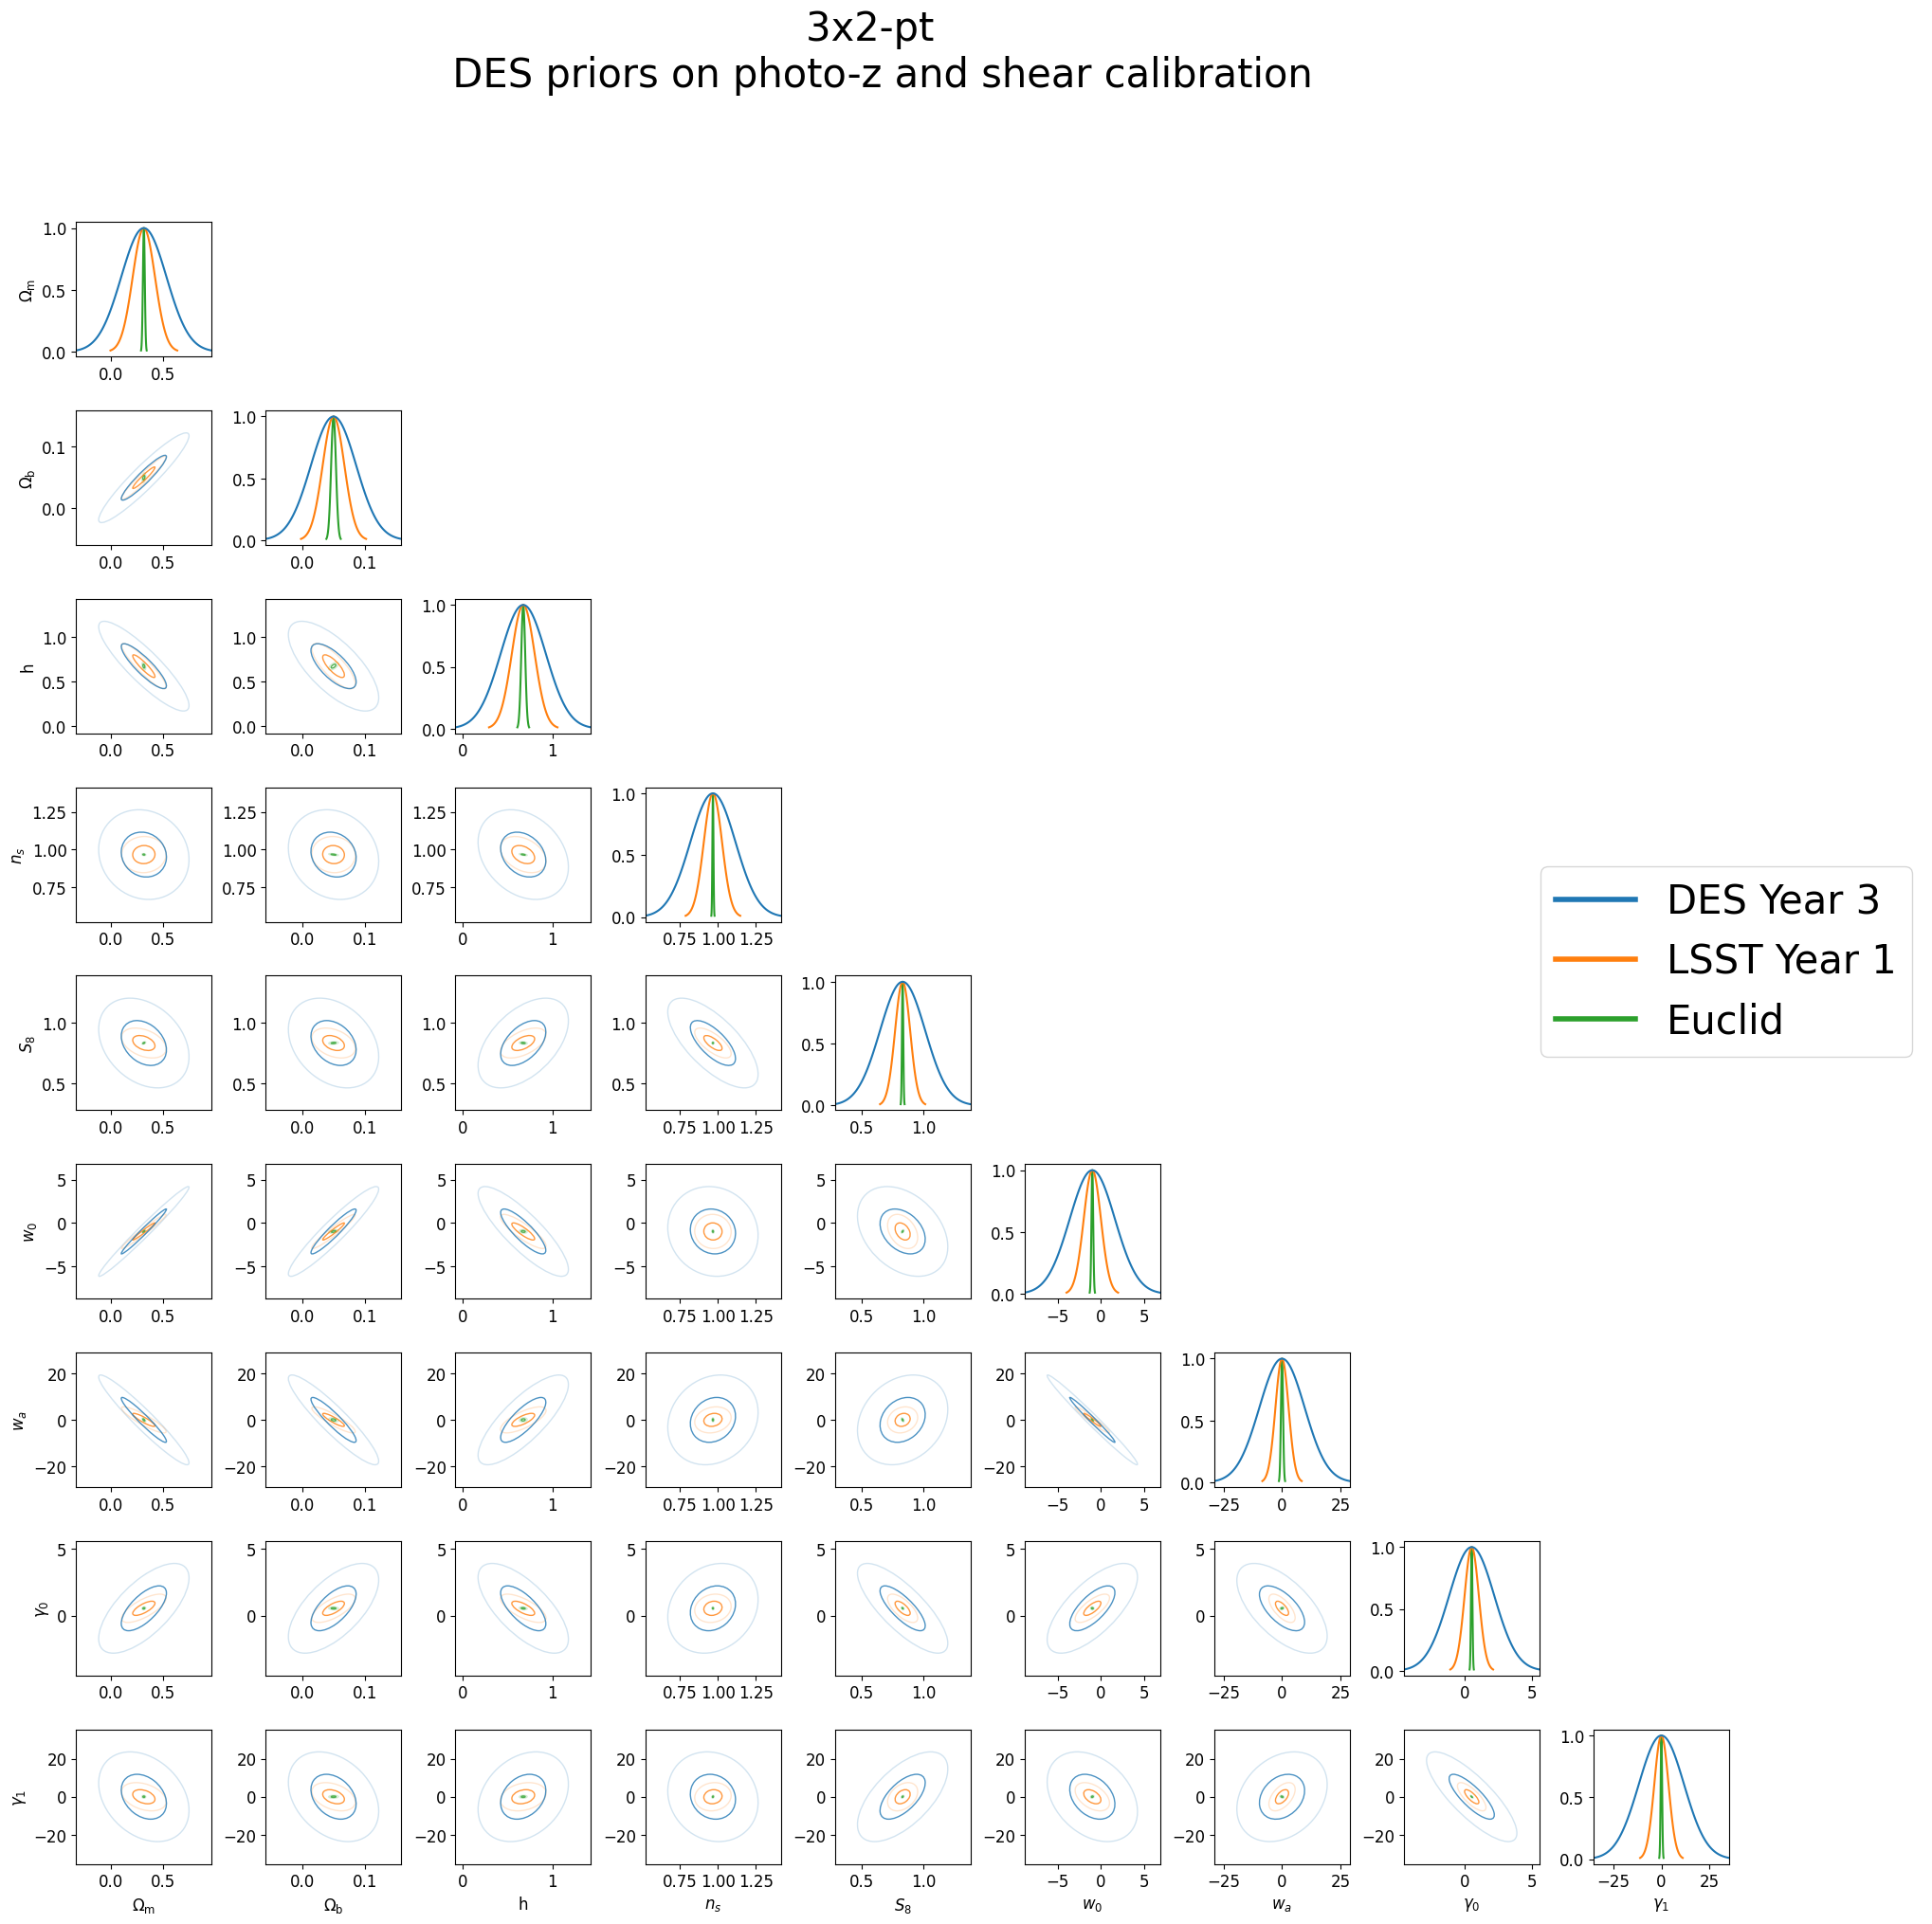

In [13]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

cov_DES = np.linalg.inv(DES_fishers_noprior[0])
cov_LSST = np.linalg.inv(LSST_fishers_noprior[0])
cov_Euclid = np.linalg.inv(Euclid_fishers_noprior[0])
cosmo_fid_vals = fid[0][:extract_params]

fig= plt.figure(figsize=(extract_params*2.5, extract_params*2.5))
plt.rcParams.update({
    "font.size": 12})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(cov_Euclid, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C2')
            plot_contours(cov_LSST, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C1')
            plot_contours(cov_DES, cosmo_fid_vals, np.array([j,i]),fill=False,antialiased=True,color='C0')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(cov_Euclid, cosmo_fid_vals, i, color='C2')
            plot_Gaussian(cov_LSST, cosmo_fid_vals, i, color='C1')
            plot_Gaussian(cov_DES, cosmo_fid_vals, i, color='C0')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('3x2-pt \n DES priors on photo-z and shear calibration', fontsize=30)

from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C2', lw=4)]
fig.legend(legend_lines, ['DES Year 3', 'LSST Year 1', 'Euclid'], fontsize=30, loc='center right')